In [1]:
import os, os.path
import sys
import pickle
import numpy 
import numpy as np
try:
    reload(orbit_helper)
except NameError:
    import orbit_helper
from galpy.potential import MWPotential2014, rl
from galpy.potential import evaluatePotentials as evalPot
from galpy.orbit import Orbit
from galpy.actionAngle import estimateDeltaStaeckel
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle_src.actionAngleStaeckel import actionAngleStaeckelSingle, estimateDeltaStaeckel
from galpy.util import bovy_plot, save_pickles, bovy_coords
from astropy import units
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

params = {'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'text.usetex': True, 'lines.linewidth' : 1, 'axes.titlesize' : 15, 'font.family' : 'serif'}
plt.rcParams.update(params)


columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Calculating Orbital Parameters using the Stæckel approximation

** SKIP THE NEXT TWO CELLS IF YOU HAVE THE SAVED PARAMETER FILE **
The calculations can take quite a while, due to the necessity to integrate orbits with very long periods enough to get a reliable measure of their parameters

_*(description of process to be filled in here)*_

In [ ]:
log10Lmin, log10Lmax= -2., 1.
log10Emin, log10Emax= -2., 0.
xmin, xmax = 0., 1.
nL, nE, nx= 101,101,31
Ls= numpy.linspace(log10Lmin,log10Lmax,nL)
Es= numpy.linspace(log10Emin,log10Emax,nL)
#Integration times
i_ts= numpy.linspace(0.,20.,1001)
#empty arrays for outputs: estimated deltas, parameters estimated with a constant delta, parameters estimated with
#an estimated delta, and parameters calculated from an orbital integration.
deltas= numpy.empty((nL,nE))
par_dconst = numpy.empty((nL,nE,4))
par_estd = numpy.empty((nL,nE,4))
par_int = numpy.empty((nL,nE,4))

for ii in tqdm_notebook(range(nL)):
    for jj in tqdm_notebook(range(nE)):
            o = orbit_helper.orbit_at_E_L(Es[jj], Ls[ii], pot=MWPotential2014)        
            #estimate delta by doing a short integration
            deltas[ii,jj,kk]= orbit_helper.estimate_delta(o, ts=i_ts, pot=MWPotential2014)
            #estimate the azimuthal period
            Tp = orbit_helper.azimuthal_period(o, pot=MWPotential2014, delta=deltas[ii,jj])
            #return nan values if Tp is not returned by galpy
            if not np.isfinite(Tp):
                par_dconst[ii,jj] = np.ones(4)*np.nan
                par_estd[ii,jj] = np.ones(4)*np.nan
                par_int[ii,jj] = np.ones(4)*np.nan
                continue
            ts= numpy.arange(0.,20.*Tp,0.01) # integrate for 20 azimuthal periods, with fixed time step (is 0.01 good enough)
            o.integrate(ts,MWPotential2014,method='symplec4_c')
            #save integration parameters
            par_int[ii,jj] = np.array([o.rperi(),o.rap(),o.zmax(),o.e()])
            #calculate staeckel approx estimation using constant delta and estimated delta
            par_estd[ii,jj] = orbit_helper.estimate_orbit_params(o, pot=MWPotential2014, delta=deltas[ii,jj,kk])
            par_dconst[ii,jj] = orbit_helper.estimate_orbit_params(o, pot=MWPotential2014, delta=0.4)


    

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/actionAngle_src/actionAngleStaeckel.py:915: RuntimeWarning: invalid value encountered in double_scalars
  use_physical=False)))/evaluateRzderivs(pot,R[ii],z[ii],use_physical=False)) for ii in range(len(R))])

/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/actionAngle_src/actionAngleStaeckel.py:916: RuntimeWarning: invalid value encountered in less
  indx= (delta2 < 0.)*(delta2 > -10.**-10.)

/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/actionAngle_src/actionAngleStaeckel.py:916: RuntimeWarning: invalid value encountered in greater
  indx= (delta2 < 0.)*(delta2 > -10.**-10.)

/home/astjmack/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/astjmack/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py

In [ ]:
np.shape(par_int)

In [ ]:
#store results
obj = [par_int ,par_dconst, par_estd, deltas]
with open('../sav/params_estimated_staeckel.dat', 'w') as f:
    pickle.dump(obj, f)

In [2]:
with open('../sav/params_estimated_staeckel.dat', 'r') as f:
    obj = pickle.load(f)
par_int ,par_dconst, par_estd, deltas = obj

/home/astjmack/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "



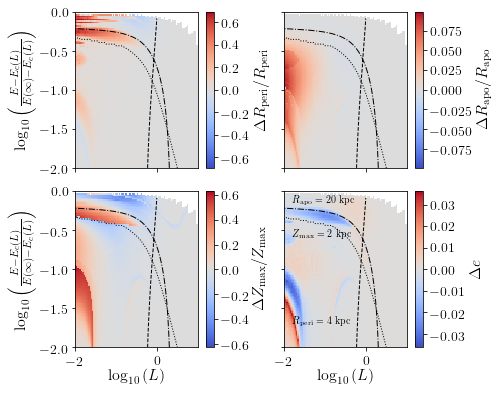

In [3]:
legrid = np.mgrid[-2.:0.:101j,-2:1.:101j]

extent = [-2., 1., -2., 0.]
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.8*textwidth)
labels = [r'$\Delta R_{\mathrm{peri}}/R_{\mathrm{peri}}$',r'$\Delta R_{\mathrm{apo}}/R_{\mathrm{apo}}$',r'$\Delta Z_{\mathrm{max}}/Z_{\mathrm{max}}$',r'$\Delta e$']

for i in range(np.shape(par_int)[2]):
    if i < 3:
        de = (par_int[:,:,i]-par_estd[:,:,i])/par_int[:,:,i]
    else:
        de = par_int[:,:,i]-par_estd[:,:,i]
    lim = np.nanmax(np.fabs(de))
    s = ax.ravel()[i].imshow(np.rot90(de), cmap=plt.cm.coolwarm, extent=extent, aspect='auto', vmin=-lim, vmax=lim)
    rpCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,0]), levels = [4./8.], colors='Black', linestyles='dashed', label=r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
    raCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,1]), levels = [20./8.], colors='Black', linestyles='dashdot', label=r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
    zmCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,2]), levels = [2./8.], colors='Black', linestyles='dotted', label=r'$Z_{\mathrm{max}} = 4\ \mathrm{kpc}$')
    plt.colorbar(s, label=labels[i], ax=ax.ravel()[i])

ax[1,1].text(-1.8,-1.7,r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
ax[1,1].text(-1.8,-0.6,r'$Z_{\mathrm{max}} = 2\ \mathrm{kpc}$')
ax[1,1].text(-1.8,-0.15,r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
ax[1,0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1,1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[1,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[0,0].legend(frameon=False, loc=3, fontsize='x-small')
fig.tight_layout()
plt.savefig('../plots/orbit_param_comparison_divergent.pdf', format='pdf')
plt.savefig('../plots/orbit_param_comparison_divergent.png', format='png', dpi=400)

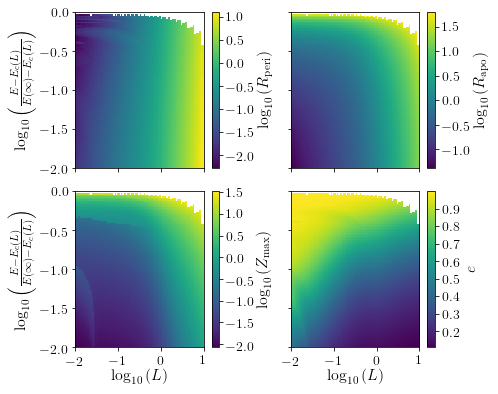

In [4]:
extent = [-2., 1., -2., 0.]
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.8*textwidth)
labels = [r'$\log_{10}{(R_{\mathrm{peri}})}$',r'$\log_{10}{(R_{\mathrm{apo}})}$',r'$\log_{10}{(Z_{\mathrm{max}})}$',r'$e$']
for i in range(np.shape(par_int)[2]):
    if i < 3:
        de = np.log10(par_int[:,:,i])
    else:
        de = par_int[:,:,i]
    s = ax.ravel()[i].imshow(np.rot90(de), cmap=plt.cm.viridis, extent=extent, aspect='auto')
    plt.colorbar(s, label=labels[i], ax=ax.ravel()[i])


ax[1,0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1,1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[1,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
fig.tight_layout()
plt.savefig('../plots/orbit_params_integration.pdf', format='pdf')
plt.savefig('../plots/orbit_params_integration.png', format='png', dpi=400)

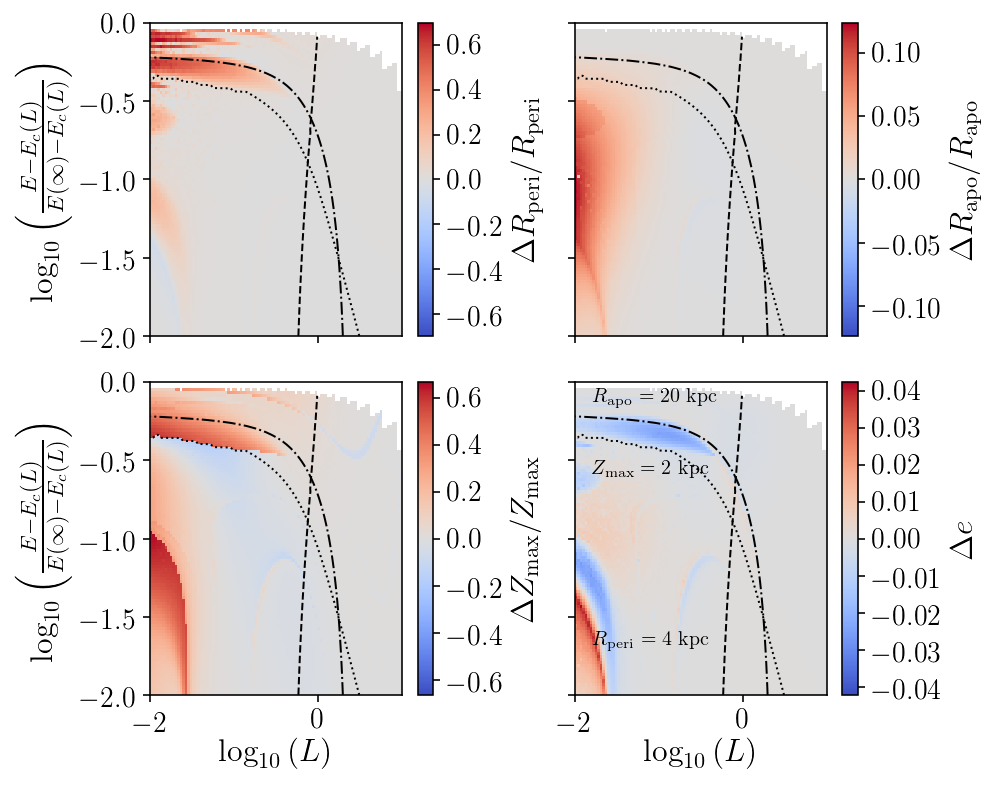

In [101]:
legrid = np.mgrid[-2.:0.:101j,-2:1.:101j]

extent = [-2., 1., -2., 0.]
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.8*textwidth)
labels = [r'$\Delta R_{\mathrm{peri}}/R_{\mathrm{peri}}$',r'$\Delta R_{\mathrm{apo}}/R_{\mathrm{apo}}$',r'$\Delta Z_{\mathrm{max}}/Z_{\mathrm{max}}$',r'$\Delta e$']

for i in range(np.shape(par_int)[2]):
    if i < 3:
        de = (par_int[:,:,i]-par_dconst[:,:,i])/par_int[:,:,i]
    else:
        de = par_int[:,:,i]-par_dconst[:,:,i]
    lim = np.nanmax(np.fabs(de))
    s = ax.ravel()[i].imshow(np.rot90(de), cmap=plt.cm.coolwarm, extent=extent, aspect='auto', vmin=-lim, vmax=lim)
    rpCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,0]), levels = [4./8.], colors='Black', linestyles='dashed', label=r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
    raCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,1]), levels = [20./8.], colors='Black', linestyles='dashdot', label=r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
    zmCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,2]), levels = [2./8.], colors='Black', linestyles='dotted', label=r'$Z_{\mathrm{max}} = 4\ \mathrm{kpc}$')
    plt.colorbar(s, label=labels[i], ax=ax.ravel()[i])

ax[1,1].text(-1.8,-1.7,r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
ax[1,1].text(-1.8,-0.6,r'$Z_{\mathrm{max}} = 2\ \mathrm{kpc}$')
ax[1,1].text(-1.8,-0.15,r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
ax[1,0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1,1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[1,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[0,0].legend(frameon=False, loc=3, fontsize='x-small')
fig.tight_layout()

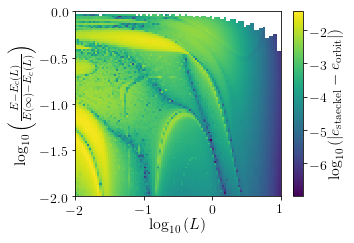

In [5]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.imshow(np.log10(np.rot90(np.fabs(par_estd[:,:,3]-par_int[:,:,3]))), cmap=plt.cm.viridis, extent=extent, aspect='auto')
plt.xlabel(r'$\log_{10}{(L)}$')
plt.ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
plt.colorbar(label=r'$\log_{10}{\left(|e_{\mathrm{staeckel}}-e_{\mathrm{orbit}}|\right)}$', ticks=[-7,-6,-5,-4,-3,-2,-1,0])
fig.tight_layout()

fig.savefig('../plots/orbit_param_comparison_abs.pdf', format='pdf')
fig.savefig('../plots/orbit_param_comparison_abs.png', format='png', dpi=400)

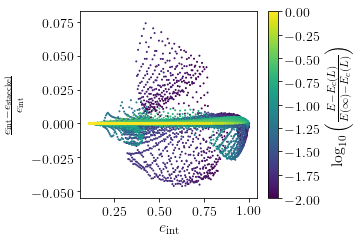

In [6]:
legrid = np.mgrid[-2.:0.:101j,0.01:10.:101j]


fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.scatter(par_int[:,:,3].ravel(), (par_int[:,:,3]-par_estd[:,:,3]).ravel()/par_int[:,:,3].ravel(), s=1., c=legrid[0].ravel(), cmap=plt.cm.viridis)
plt.colorbar(label=r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
plt.xlabel(r'$e_{\mathrm{int}}$')
plt.ylabel(r'$\frac{e_{\mathrm{int}}-e_{\mathrm{staeckel}}}{e_{\mathrm{int}}}$')
fig.tight_layout()
plt.savefig('../plots/orbit_param_comparison_scatter_energy.pdf', format='pdf')
plt.savefig('../plots/orbit_param_comparison_scatter_energy.png', format='png', dpi=400)

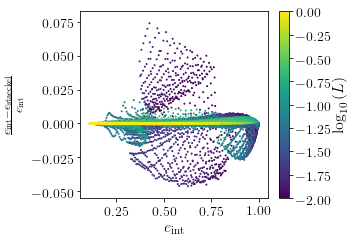

In [7]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.scatter(par_int[:,:,3].ravel(), ((par_int[:,:,3]-par_estd[:,:,3])/par_int[:,:,3]).ravel(), s=1., c=legrid[0].ravel(), cmap=plt.cm.viridis)
plt.colorbar(label=r'$\log_{10}{\left(L\right)}$')
plt.xlabel(r'$e_{\mathrm{int}}$')
plt.ylabel(r'$\frac{e_{\mathrm{int}}-e_{\mathrm{staeckel}}}{e_{\mathrm{int}}}$')
fig.tight_layout()
plt.savefig('../plots/orbit_param_comparison_scatter_L.pdf', format='pdf')
plt.savefig('../plots/orbit_param_comparison_scatter_L.png', format='png', dpi=400)

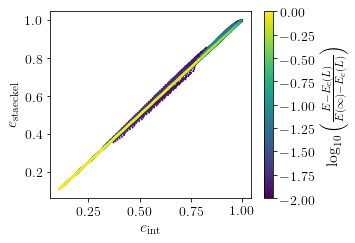

In [8]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.scatter(par_int[:,:,3].ravel(), par_estd[:,:,3].ravel(), s=1., c=legrid[0].ravel(), cmap=plt.cm.viridis)
plt.colorbar(label=r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
plt.xlabel(r'$e_{\mathrm{int}}$')
plt.ylabel(r'$e_{\mathrm{staeckel}}$')
fig.tight_layout()

In [9]:
print np.nanstd((par_estd[:,:,3]-par_int[:,:,3]).ravel()/par_int[:,:,3].ravel())
print np.nanmean((par_estd[:,:,3]-par_int[:,:,3]).ravel()/par_int[:,:,3].ravel())

0.00929309454892
0.00063626633539


(-3.0, 3)

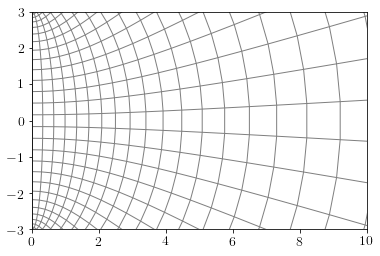

In [19]:
uv_grid = np.mgrid[0.:np.pi:30j, 0.:np.pi:30j]
delta = 0.375
R = delta*np.sinh(uv_grid[0])*np.sin(uv_grid[1])*8
Z = delta*np.cosh(uv_grid[0])*np.cos(uv_grid[1])*8
plt.plot(R, Z, color='Gray')
plt.plot(R.T, Z.T, color='Gray')

plt.xlim(0.,10.)
plt.ylim(-3.,3)


In [3]:
def orbit_atEL(E, L, x = 4./5., ts=numpy.linspace(0.,20.,1001)):
    #Integration times
    i_ts= ts
    Einf= evalPot(MWPotential2014,10.**12.,0.)
    #Calculate Ec\n",
    Rc= rl(MWPotential2014,10**L)
    Ec= evalPot(MWPotential2014,Rc,0.)+0.5*(10**L)**2./Rc**2.
    Es= Ec+(Einf-Ec)*10.**E
    #Setup an orbit with this energy and angular momentum
    Er= 2.*(Es-Ec) #Random energy times 2 = vR^2 + vz^2\n",
    vR= numpy.sqrt(x*Er)
    vz= numpy.sqrt((1-x)*Er)
    o= Orbit([Rc,vR,(10**L)/Rc,0.,vz,0.])
    #estimate delta by doing a short integration\n",
    o.integrate(i_ts,MWPotential2014,method='symplec4_c')
    return o

def surface_section(Rs,zs,vRs):
    # Find points where the orbit crosses z from - to + 3 
    shiftzs= numpy.roll(zs,-1)
    indx= (zs[:-1] < 0.)*(shiftzs[:-1] > 0.)
    return (Rs[:-1][indx],vRs[:-1][indx])

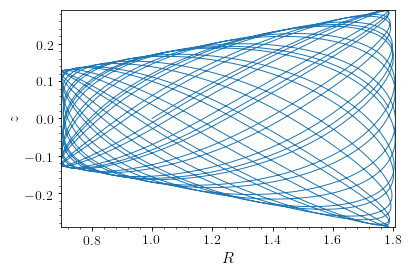

In [56]:

o = orbit_atEL(-1.,0., ts=numpy.linspace(0.,300.,10000))

ts=numpy.linspace(0.,120.,10000)
Rs = o.R(ts)
Zs = o.z(ts)

delta = orbit_helper.estimate_delta(o, ts=ts, pot=MWPotential2014)
param = orbit_helper.estimate_orbit_params(o,pot=MWPotential2014, delta=delta)
aASS = actionAngleStaeckelSingle(o,pot=MWPotential2014,delta=delta)
umin, umax= aASS.calcUminUmax()

o.plot()

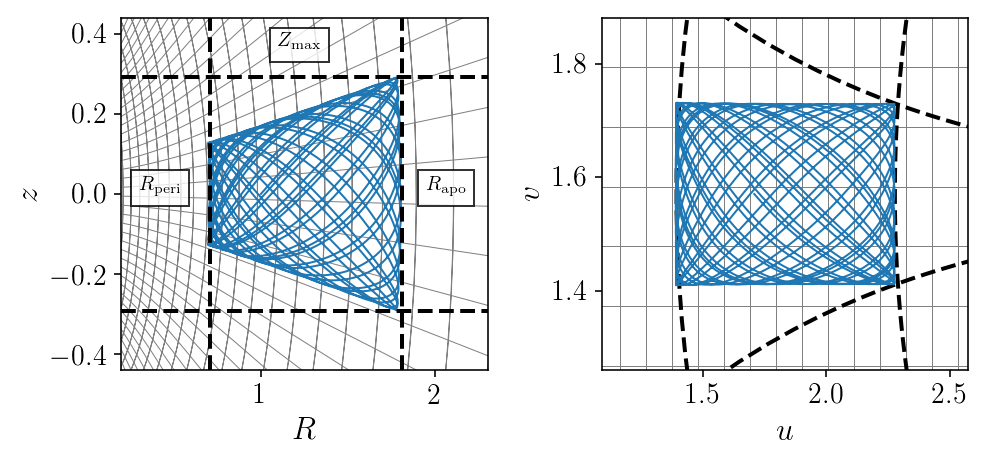

In [100]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(textwidth, columnwidth)
u, v = bovy_coords.Rz_to_uv(Rs, Zs, delta=delta)
maxu, minu = np.max(u), np.min(u)
maxv, minv = np.max(v), np.min(v)
maxR, maxZ = bovy_coords.uv_to_Rz(maxu,minv,delta=delta)
minR, minZ = bovy_coords.uv_to_Rz(minu,maxv,delta=delta)
uv_grid = np.mgrid[0.:4*np.pi:120j, 0.:4*np.pi:120j]
delta = delta
R = delta*np.sinh(uv_grid[0])*np.sin(uv_grid[1])
Z = delta*np.cosh(uv_grid[0])*np.cos(uv_grid[1])
ax[0].plot(R, Z, color='Gray', lw=0.5)
ax[0].plot(R.T, Z.T, color='Gray', lw=0.5)
ax[0].plot(o.R(ts), o.z(ts))
ax[0].set_xlim(np.min(o.R(ts))-0.5, np.max(o.R(ts))+0.5)
ax[0].set_ylim(np.min(o.z(ts))-0.15, np.max(o.z(ts))+0.15)
ax[0].set_xlabel(r'$R$')
ax[0].set_ylabel(r'$z$')
ax[0].axvline(param[0], lw=2., c='Black', linestyle='dashed')
ax[0].axvline(param[1], lw=2., c='Black', linestyle='dashed')
ax[0].axhline(param[2], lw=2., c='Black', linestyle='dashed')
ax[0].axhline(-param[2], lw=2., c='Black', linestyle='dashed')
uv_grid = np.mgrid[0.:4*np.pi:120j, 0.:4*np.pi:120j]

R = uv_grid[0]
Z = uv_grid[1]
zmax_R = np.linspace(0.,5.,40)
zmax_z = np.ones(40)*param[2]
rperi_R = np.ones(40)*param[0]
rperi_z = np.linspace(-1,1,40)
rapo_R = np.ones(40)*param[1]
rapo_z = np.linspace(-1,1,40)
ax[1].plot(R, Z, color='Gray', lw=0.5)
ax[1].plot(R.T, Z.T, color='Gray', lw=0.5)
zmax_u, zmax_v = bovy_coords.Rz_to_uv(zmax_R, zmax_z,delta=delta)
ax[1].plot(zmax_u, zmax_v, lw=2., c='Black', linestyle='dashed')
zmax_u, zmax_v = bovy_coords.Rz_to_uv(zmax_R, -zmax_z,delta=delta)
ax[1].plot(zmax_u, zmax_v, lw=2., c='Black', linestyle='dashed')
rperi_u, rperi_v = bovy_coords.Rz_to_uv(rperi_R, rperi_z,delta=delta)
ax[1].plot(rperi_u, rperi_v, lw=2., c='Black', linestyle='dashed')
rapo_u, rapo_v = bovy_coords.Rz_to_uv(rapo_R, rapo_z,delta=delta)
ax[1].plot(rapo_u, rapo_v, lw=2., c='Black', linestyle='dashed')
ax[1].plot(u, v)
ax[1].set_xlim(np.min(u)-0.3, np.max(u)+0.3)
ax[1].set_ylim(np.min(v)-0.15, np.max(v)+0.15)
ax[1].set_xlabel(r'$u$')
ax[1].set_ylabel(r'$v$')

fig.tight_layout()

ax[0].text(0.3,0.,r'$R_\mathrm{peri}$', bbox={'facecolor':'White', 'alpha':0.8, 'pad':4})
ax[0].text(1.95,0.,r'$R_\mathrm{apo}$', bbox={'facecolor':'White', 'alpha':0.8, 'pad':4})
ax[0].text(1.1,0.36,r'$Z_\mathrm{max}$', bbox={'facecolor':'White', 'alpha':0.8, 'pad':4})


plt.savefig('../plots/example_orbit.pdf', format='pdf', dpi=400)
plt.savefig('../plots/example_orbit.png', format='png', dpi=400)


#plt.xlim(xlim[0]-0.2,xlim[1]+0.2)
#plt.ylim(ylim[0]-0.2,ylim[1]+0.2)
#plt.scatter(maxR, maxZ, c='Red')

In [75]:
zmax_u

array([  0.00000000e+00,   1.12626488e-01,   2.44476549e-01,
         4.18054920e-01,   6.62988703e-01,   1.02108425e+00,
         1.55346285e+00,   2.35099318e+00,   3.54980114e+00,
         5.35450444e+00,   8.07313760e+00,   1.21697286e+01,
         1.83435013e+01,   2.76482217e+01,   4.16720596e+01,
         6.28086640e+01,   9.46657214e+01,   1.42680732e+02,
         2.15049103e+02,   3.24122981e+02,   4.88519563e+02,
         7.36298768e+02,   1.10975261e+03,   1.67262381e+03,
         2.52098564e+03,   3.79964015e+03,   5.72683359e+03,
         8.63150763e+03,   1.30094445e+04,   1.96078894e+04,
         2.95530933e+04,   4.45425462e+04,   6.71347127e+04,
         1.01185721e+05,   1.52507543e+05,   2.29860009e+05,
         3.46445971e+05,   5.22164822e+05,   7.87009012e+05,
         1.18618329e+06])

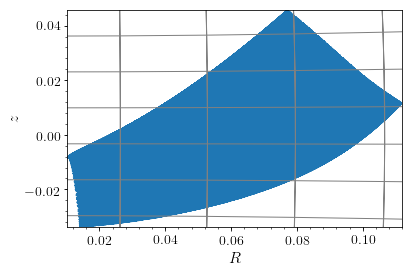

In [12]:
o = orbit_atEL(-1.2,-2., ts=numpy.linspace(0.,300.,10000))

ts=numpy.linspace(0.,30.,10000)
Rs = o.R(ts)
Zs = o.z(ts)
u, v = bovy_coords.Rz_to_uv(Rs, Zs, delta=0.375)
maxu, minu = np.max(u), np.min(u)
maxv, minv = np.max(v), np.min(v)
maxR, maxZ = bovy_coords.uv_to_Rz(maxu,minv,delta=0.375)
minR, minZ = bovy_coords.uv_to_Rz(minu,maxv,delta=0.375)

o.plot()
uv_grid = np.mgrid[0.:4*np.pi:180j, 0.:4*np.pi:180j]
delta = 0.375
R = delta*np.sinh(uv_grid[0])*np.sin(uv_grid[1])
Z = delta*np.cosh(uv_grid[0])*np.cos(uv_grid[1])
plt.plot(R, Z, color='Gray')
plt.plot(R.T, Z.T, color='Gray')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
#plt.xlim(xlim[0]-0.2,xlim[1]+0.2)
#plt.ylim(ylim[0]-0.2,ylim[1]+0.2)
#plt.scatter(maxR, maxZ, c='Red')
#plt.scatter(np.sqrt(maxR**2+maxZ**2), 0., c='Red')

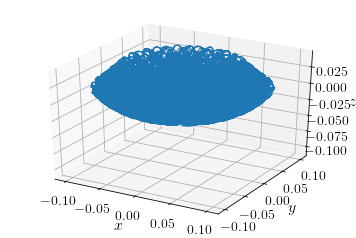

In [13]:
o.plot3d()

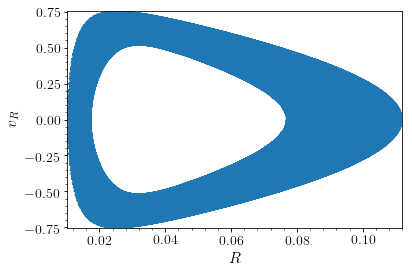

In [14]:
o.plot(d1='R', d2='vR')

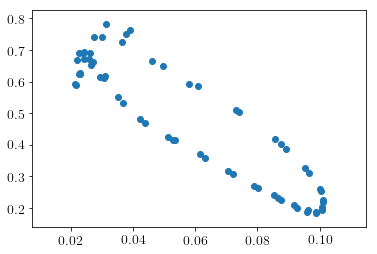

In [15]:
sectRs,sectvRs=surface_section(o.R(ts),o.z(ts),o.vR(ts)) 
plt.scatter(sectRs,sectvRs)




This orbit has a cool surface of section...

In [16]:
o.animate(width=800,
          d1=['R',lambda t: bovy_coords.Rz_to_uv(o.R(t),o.z(t),delta=0.45)[0]],
          d2=['vR',lambda t: bovy_coords.vRvz_to_pupv(o.vR(t),o.vz(t),o.R(t),o.z(t),delta=0.45)[0]],
         xlabel=[None,'u'],ylabel=[None,'p_u'])

In [17]:
o.animate(d1=['R','x'],d2=['z','y'],width=800)

In [18]:
o.animate(d1=['y'],d2=['z'],width=800)

In [ ]:
log10Lmin, log10Lmax= -0.5, 0.5
log10Emin, log10Emax= -2., -0.5
xmin, xmax = 0., 1.
nL, nE, nx= 31,31,31
Ls= numpy.linspace(log10Lmin,log10Lmax,nL)
Es= numpy.linspace(log10Emin,log10Emax,nL)
xs = numpy.linspace(xmin, xmax, nx)
#Integration times
i_ts= numpy.linspace(0.,20.,1001)
#empty arrays for outputs: estimated deltas, parameters estimated with a constant delta, parameters estimated with
#an estimated delta, and parameters calculated from an orbital integration.
deltas= numpy.empty((nL,nE,nx))
par_dconst = numpy.empty((nL,nE,nx,4))
par_estd = numpy.empty((nL,nE,nx,4))
par_int = numpy.empty((nL,nE,nx,4))

for ii in tqdm_notebook(range(nL)):
    for jj in tqdm_notebook(range(nE)):
        for kk in tqdm_notebook(range(nx)):
            o = orbit_helper.orbit_at_E_L(Es[jj], Ls[ii], x=xs[kk], pot=MWPotential2014)        
            #estimate delta by doing a short integration
            deltas[ii,jj,kk]= orbit_helper.estimate_delta(o, ts=i_ts, pot=MWPotential2014)
            #estimate the azimuthal period
            Tp = orbit_helper.azimuthal_period(o, pot=MWPotential2014, delta=deltas[ii,jj,kk])
            #return nan values if Tp is not returned by galpy
            if not np.isfinite(Tp):
                par_dconst[ii,jj,kk] = np.ones(4)*np.nan
                par_estd[ii,jj,kk] = np.ones(4)*np.nan
                par_int[ii,jj,kk] = np.ones(4)*np.nan
                continue
            ts= numpy.arange(0.,20.*Tp,0.01) # integrate for 20 azimuthal periods, with fixed time step (is 0.01 good enough)
            o.integrate(ts,MWPotential2014,method='symplec4_c')
            #save integration parameters
            par_int[ii,jj,kk] = np.array([o.rperi(),o.rap(),o.zmax(),o.e()])
            #calculate staeckel approx estimation using constant delta and estimated delta
            par_estd[ii,jj,kk] = orbit_helper.estimate_orbit_params(o, pot=MWPotential2014, delta=deltas[ii,jj,kk])
            par_dconst[ii,jj,kk] = orbit_helper.estimate_orbit_params(o, pot=MWPotential2014, delta=0.4)


    

/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/actionAngle_src/actionAngleStaeckel.py:915: RuntimeWarning: invalid value encountered in double_scalars
  use_physical=False)))/evaluateRzderivs(pot,R[ii],z[ii],use_physical=False)) for ii in range(len(R))])

/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/actionAngle_src/actionAngleStaeckel.py:916: RuntimeWarning: invalid value encountered in less
  indx= (delta2 < 0.)*(delta2 > -10.**-10.)

/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/actionAngle_src/actionAngleStaeckel.py:916: RuntimeWarning: invalid value encountered in greater
  indx= (delta2 < 0.)*(delta2 > -10.**-10.)

/home/astjmack/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/astjmack/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py

In [104]:
#store results
obj = [par_int ,par_dconst, par_estd, deltas]
with open('../sav/params_estimated_staeckel_withV_zoomed.dat', 'w') as f:
    pickle.dump(obj, f)

In [105]:
with open('../sav/params_estimated_staeckel_withV_zoomed.dat', 'r') as f:
    obj = pickle.load(f)
par_int ,par_dconst, par_estd, deltas = obj

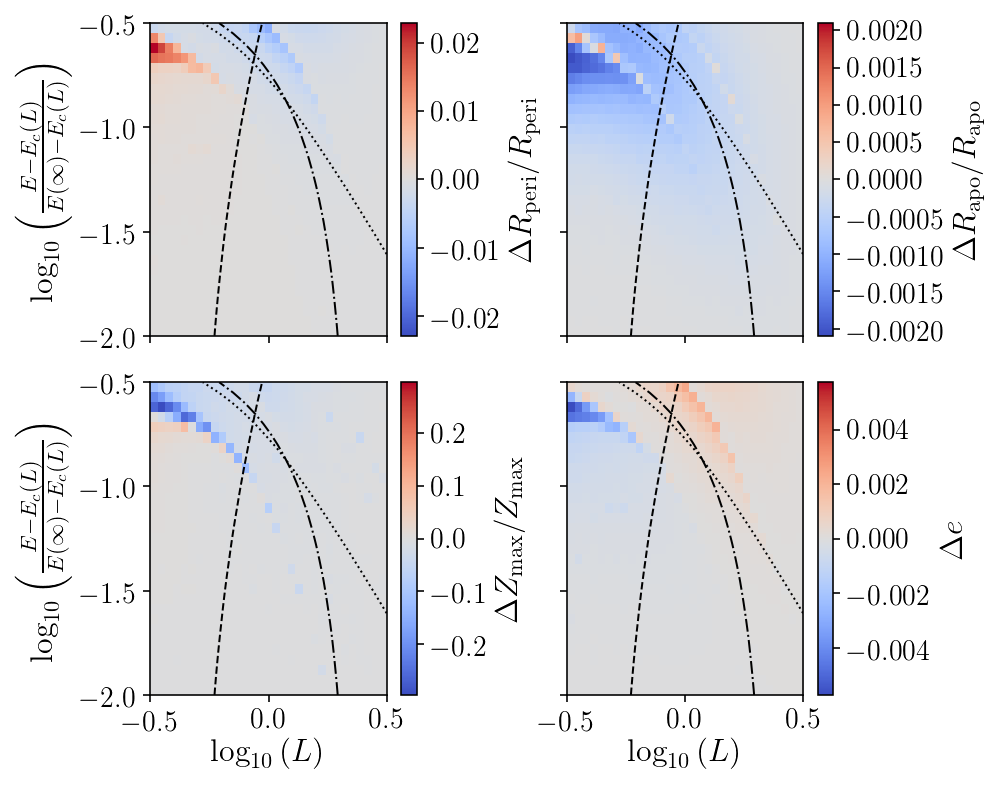

In [120]:
legrid = np.mgrid[-2.:-0.5:31j,-0.5:0.5:31j]
xi = 28
extent = [-0.5, 0.5, -2, -0.5]
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.8*textwidth)
labels = [r'$\Delta R_{\mathrm{peri}}/R_{\mathrm{peri}}$',r'$\Delta R_{\mathrm{apo}}/R_{\mathrm{apo}}$',r'$\Delta Z_{\mathrm{max}}/Z_{\mathrm{max}}$',r'$\Delta e$']

for i in range(np.shape(par_int)[3]):
    if i < 3:
        de = (par_int[:,:,xi,i]-par_estd[:,:,xi,i])/par_int[:,:,xi,i]
    else:
        de = par_int[:,:,xi,i]-par_estd[:,:,xi,i]
    lim = np.nanmax(np.fabs(de))
    s = ax.ravel()[i].imshow(np.rot90(de), cmap=plt.cm.coolwarm, extent=extent, aspect='auto', vmin=-lim, vmax=lim)
    rpCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,xi,0]), levels = [4./8.], colors='Black', linestyles='dashed', label=r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
    raCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,xi,1]), levels = [20./8.], colors='Black', linestyles='dashdot', label=r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
    zmCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,xi,2]), levels = [2./8.], colors='Black', linestyles='dotted', label=r'$Z_{\mathrm{max}} = 4\ \mathrm{kpc}$')
    plt.colorbar(s, label=labels[i], ax=ax.ravel()[i])

#ax[1,1].text(-1.8,-1.7,r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
#ax[1,1].text(-1.8,-0.6,r'$Z_{\mathrm{max}} = 2\ \mathrm{kpc}$')
#ax[1,1].text(-1.8,-0.15,r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
ax[1,0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1,1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[1,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[0,0].legend(frameon=False, loc=3, fontsize='x-small')
fig.tight_layout()

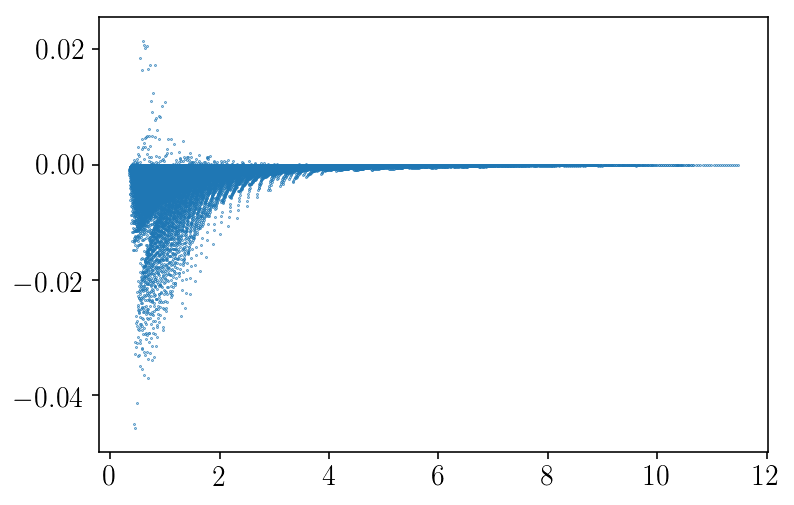

In [123]:
plt.scatter(par_int[:,:,:,1].ravel(), (par_int[:,:,:,1].ravel()-par_estd[:,:,:,1].ravel())/par_int[:,:,:,1].ravel(), s=0.1)

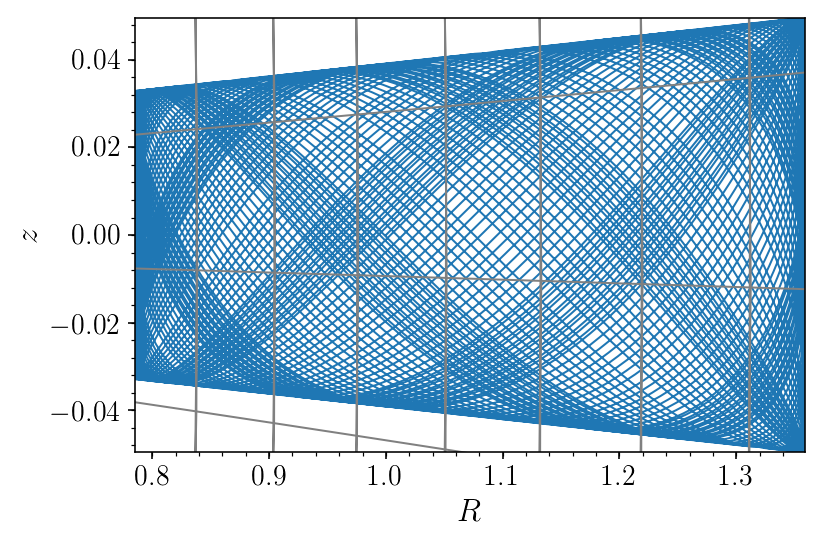

In [138]:
log10Lmin, log10Lmax= -0.5, 0.5
log10Emin, log10Emax= -2., -0.5
xmin, xmax = 0., 1.
nL, nE, nx= 31,31,31
Ls= numpy.linspace(log10Lmin,log10Lmax,nL)
Es= numpy.linspace(log10Emin,log10Emax,nL)
xs = numpy.linspace(xmin, xmax, nx)
o = orbit_atEL(-1.5,-0., x= xs[28],  ts=numpy.linspace(0.,300.,10000))

est_delta = orbit_helper.estimate_delta(o)
o = orbit_atEL(-1.5,-0., x= xs[28],  ts=numpy.linspace(0.,300.,10000))


ts=numpy.linspace(0.,30.,10000)
Rs = o.R(ts)
Zs = o.z(ts)
u, v = bovy_coords.Rz_to_uv(Rs, Zs, delta=0.375)
maxu, minu = np.max(u), np.min(u)
maxv, minv = np.max(v), np.min(v)
maxR, maxZ = bovy_coords.uv_to_Rz(maxu,minv,delta=0.375)
minR, minZ = bovy_coords.uv_to_Rz(minu,maxv,delta=0.375)

o.plot()
uv_grid = np.mgrid[0.:4*np.pi:180j, 0.:4*np.pi:180j]
delta = 0.375
R = delta*np.sinh(uv_grid[0])*np.sin(uv_grid[1])
Z = delta*np.cosh(uv_grid[0])*np.cos(uv_grid[1])
plt.plot(R, Z, color='Gray')
plt.plot(R.T, Z.T, color='Gray')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()


In [139]:
o.animate(width=800,
          d1=['R',lambda t: bovy_coords.Rz_to_uv(o.R(t),o.z(t),delta=est_delta)[0]],
          d2=['z',lambda t: bovy_coords.Rz_to_uv(o.R(t),o.z(t),delta=est_delta)[1]],
         xlabel=[None,'u'],ylabel=[None,'p_u'])

In [140]:
o.animate(width=800,
          d1=['R',lambda t: bovy_coords.Rz_to_uv(o.R(t),o.z(t),delta=est_delta)[0]],
          d2=['vR',lambda t: bovy_coords.vRvz_to_pupv(o.vR(t),o.vz(t),o.R(t),o.z(t),delta=est_delta)[0]],
         xlabel=[None,'u'],ylabel=[None,'p_u'])

In [141]:
o.animate(width=800,
          d1=['vR',lambda t: bovy_coords.vRvz_to_pupv(o.vR(t),o.vz(t),o.R(t),o.z(t),delta=est_delta)[0]],
          d2=['vz',lambda t: bovy_coords.vRvz_to_pupv(o.vR(t),o.vz(t),o.R(t),o.z(t),delta=est_delta)[1]],
         xlabel=[None,'p_u'],ylabel=[None,'p_v'])

In [4]:
log10Lmin, log10Lmax= -0.5, 0.5
log10Emin, log10Emax= -2., -0.5
xmin, xmax = 0., 1.
nL, nE, nx= 31,31,31
Ls= numpy.linspace(log10Lmin,log10Lmax,nL)
Es= numpy.linspace(log10Emin,log10Emax,nL)
xs = numpy.linspace(xmin, xmax, nx)
o = orbit_atEL(-1.5,-0., x= xs[28],  ts=numpy.linspace(0.,300.,10000))

est_delta = orbit_helper.estimate_delta(o)
o = orbit_atEL(-1.5,-0., x= xs[28],  ts=numpy.linspace(0.,300.,10000))


ts=numpy.linspace(0.,30.,10000)

In [5]:
t = orbit_helper.params_along_orbit(o)

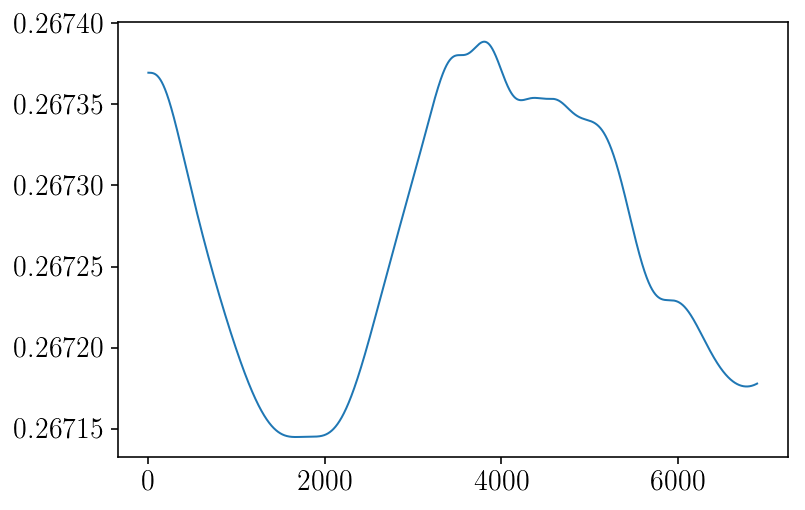

In [9]:
plt.plot(t[0])

In [8]:
t[0]

array([ 0.26736953,  0.26736953,  0.26736953, ...,  0.26717783,
        0.26717786,  0.26717789])